In [1]:
pip install biopython

  Using cached biopython-1.84-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import re
import os
import copy
import pickle
import gzip
import math
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import statistics
from matplotlib_venn import venn3
#stats
from scipy.signal import find_peaks
from itertools import combinations#
from itertools import combinations_with_replacement
from scipy.stats import linregress
date = datetime.datetime.now().strftime("%Y-%m-%d")
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
#from colorspacious import cspace_converter

In [3]:
def draw_ref_maxi(ax):#leish tarentolae annotation
    drawarrow(ax,438,1610,'12S rRNA',edited=False)
    drawarrow(ax,1639,2249,'9S rRNA',edited=False)
    drawarrow(ax,2380,2600,'ND8',upper=False)
    drawarrow(ax,2960,2700,'ND9')
    drawarrow(ax,3268,2966,'MURF5',edited=False,upper=False)
    drawarrow(ax,3315,4458,'ND7')
    drawarrow(ax,4511,5362,'COX3',upper=False)
    #drawarrow(ax,4924,4877,'gRNA_MURF2',2,edited=False,txtcolor='red')
    drawarrow(ax,5403,6481,'CYB')
    drawarrow(ax,6521,7123,'A6')
    drawarrow(ax,8456,7125,'MURF1(ND2)',edited=False)
    drawarrow(ax,8490,8600,'GR3',upper=False)
    drawarrow(ax,9489,8548,'ND1',edited=False)
    drawarrow(ax,9496,10124,'COX2')
    drawarrow(ax,10146,11190,'MURF2')
    drawarrow(ax,12830,11181,'COX1',edited=False)
    drawarrow(ax,13042,12893,'GR4',upper=False)
    #drawarrow(ax,12750,12797,'gRNA_MURF2',2,edited=False,txtcolor='red')#on sense strand
    drawarrow(ax,13152,14465,'ND4',edited=False)
    drawarrow(ax,14660,14501,'ND3')
    drawarrow(ax,14673,14854,'RPS12',upper=False)
    drawarrow(ax,14924,16696,'ND5',edited=False)
#draw maxicircle genes
def drawarrow(ax,xstart,xend,name,txty=70,edited=True,txtcolor='k',hw=10,upper=True):
    if (xend-xstart)<150 and (xend-xstart)>-150:
        hl=xend-xstart-1
    else:
        hl=150
    if xstart<xend:
        if edited==False:
            ax.arrow(xstart,txty,(xend-xstart-hl),0,head_width=hw, head_length=hl, width=hw*0.6,fc='cornflowerblue', 
                      ec='None')
        else:
            ax.arrow(xstart,txty,(xend-xstart-hl),0,head_width=hw, head_length=hl, width=hw*0.6,fc='cornflowerblue', 
                      ec='black',hatch='////')
    else:
        if edited==False:
            ax.arrow(xstart,txty,(xend-xstart+hl),0,head_width=hw, head_length=hl, width=hw*0.6,fc='darkorange', 
                      ec='None')
        else:
            ax.arrow(xstart,txty,(xend-xstart+hl),0,head_width=hw, head_length=hl, width=hw*0.6,fc='darkorange', 
                          ec='black',hatch='////')
    if upper==True:
        ax.text(min(xstart,xend),txty+hw/2,name,color=txtcolor)
    else:
        ax.text(min(xstart,xend),txty-hw,name,color=txtcolor)
#draw gRBAs
def add_gRNA(ax,text,x,txth=50):
    arrowprops = dict( arrowstyle = "->", 
    connectionstyle = "angle, angleA = 0, angleB = 90,rad = 10") 
    ax.annotate(text,(x,70),(x,txth),arrowprops = arrowprops)

In [4]:
#Leishmania tarentolae
lt=[('gM150',102,90), ('gND7-II_26-60',347,50), ('gCYb-II_30-76',2239,90), ('gMURF2-I_74-88',9893,90), 
        ('gCOXII_507-512',10117,50), ('gMURF2-II_30-76',13090,90),('gND7-I_231-250',16724,100), ('gCYb-I_77-94',16754,50),('gRPS12-VI_34-89',16976,90)]
#L. peruviana
hr78=[('gND9_563-610',234,40),('gND9_205-252',363,100),('gGR3_142-190',405,45),
      ('gND9_90-133',557,95),('gND7-II_17-65',689,50), 
    ('gGR4_24-70',1577,90),('gCYb-II_21-71',2595,85),('gND9_304-355',8444,90),
      ('gGR4_251-304',8590,50),('gGR3_66-112',10790,50),
    ('gGR4_81-122/ND8_1-42',11117,100),('gGR4_248-289',11128,90),
      ('gGR3_97-139',11586,55),('gMURF2-II_26-83',13452,90),
      ('gCOXII_507-512',10117+689-347,45),('gCYb_I_48-94',17007,100),('gCR4_399-445',17213,95),
      ('gA6_114-159',17314,50),('gND8_381-425',18651,90),('gGR3_94-138',18671,55),('gND9_322-365',18674,85)]
lca04=[('gND9_563-610',133,40),('gND9_205-252',262,100),('gGR3_142-190',304,45),('gA6_135-175',344,50),
       ('gND9_90-133',456,95),('gND7-II_17-65',588,90), 
    ('gGR4_24-70',1476,85),('gCYb-II_21-71',2489,80),('gND9_304-355',8336,90),
       ('gGR4_251-304',8482,50),('gGR3_66-112',10682,45),('gCOXII_507-512',10117+588-347,40),
    ('gGR4_81-122/ND8_1-42',11009,100),('gGR4_248-289',11020,95),('gGR3_97-139',11478,50),
       ('gMURF2-II_26-83',13344,90),('gCYb-I_48-94',16969,100), 
    ('gGR4_399-445',17105,90),('gA6_112-157',17206,50)] 
#L. braziliensis
lc1412=[('gND9_205-252',1246,40),('gGR3_142-190',1288,45),('gND9_90-133',1439,100),('gND7-II_17-65',1571,95), 
    ('gGR4_24-70',2459,90),('gCYb-II_21-71',3532,85),('gND9_304-355',9368,90),
        ('gGR4_251-304',9514,55),('gGR3_66-122',11714,50),('gCOXII_507-512',10117+1571-347,45),
    ('gGR4_81-122/ND8_1-42',12041,100),('gGR4_248-289',12052,90),
        ('gGR3_97-139',12510,55),('gMURF2-II_26-83',14376,90),('gCYb-I_48-94',18001,100), 
    ('gGR4_399-445',18137,95),('gA6_117-157',18231,45),('gGR4_254-298',19636,90),('gGR3_153-194',19670,50)] 
#hybrid
HR434=[('gND9',1246,50),('gGR3',1288,45),('gND9',1439,100),('gND7',1571,90), 
    ('gGR4',2459,90),('gCYb',3532,90),('gND9',9368,90),('gGR4',9514,50),('gGR3',11714,50),('gCOXII_507-512',10117+1571-347,45),
    ('gGR4_81-122/ND8_1-42',12041,100),('gGR4',12052,90),('gGR3',12510,50),('gMURF2',14376,90),('gCYb',18001,100), 
    ('gCR4',18137,90),('gA6',18231,50),('gGR4',19636,100),('gGR3',19670,50)] 
#Crithidia fasciculata
cf=[('gND7-II',347,50), ('gCYb-II',2239,90), ('gMURF2-I_60-86',9893,90), ('gCOXII_507-512',10117,50), 
        ('gMURF2-II_18-83',13090,90), ('gND7-I',16724,90), ('gCYb-I',16754,50)]
#T. congo
tc=[('gND7_1200-1252',15086 ,90), ('gCOXII_507-512',8396 ,50), ('gMURF2-II_40-80',11425,90)]
#T. brucei
tb=[('gCOXII_507-512',8396 ,50), ('gMURF2-II_30-76',11425,90)]
def anotate_maxi(species,gRNAs,adj=0):
    fig, ax = plt.subplots(figsize=(15,5))
    plt.axis('off')
    draw_ref_maxi(ax)
    for grna in gRNAs:
        add_gRNA(ax,grna[0],grna[1]-adj,txth=grna[2])
    ax.text(0,20,species,fontstyle='italic', fontsize=25)
    ax.set_xlim(-200,19000)
    ax.set_ylim(30,110)
    plt.show()

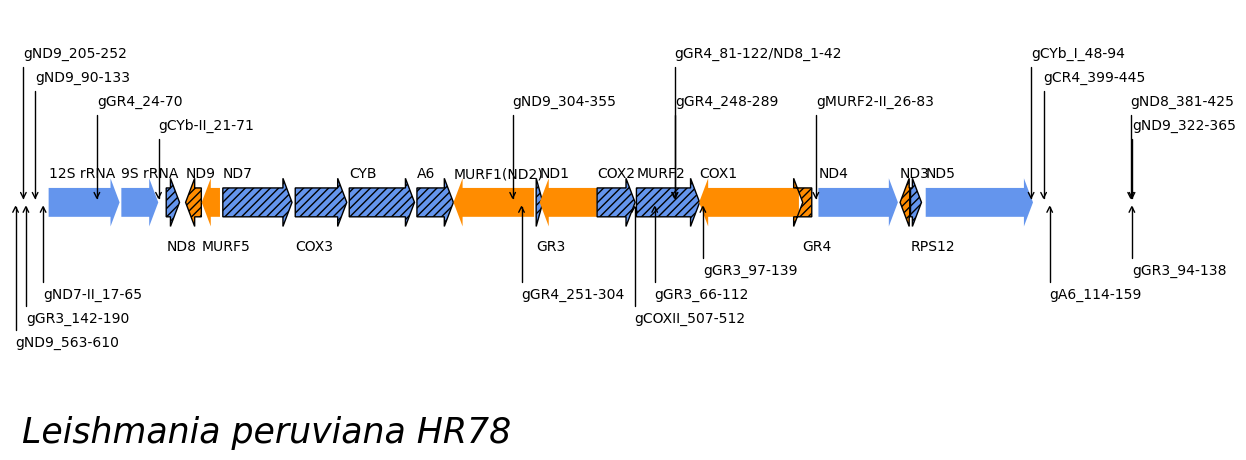

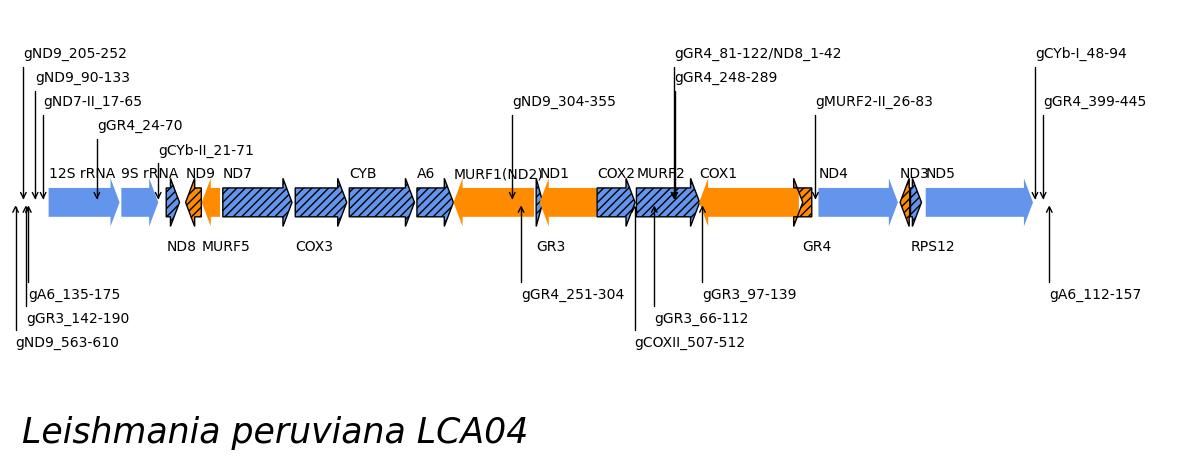

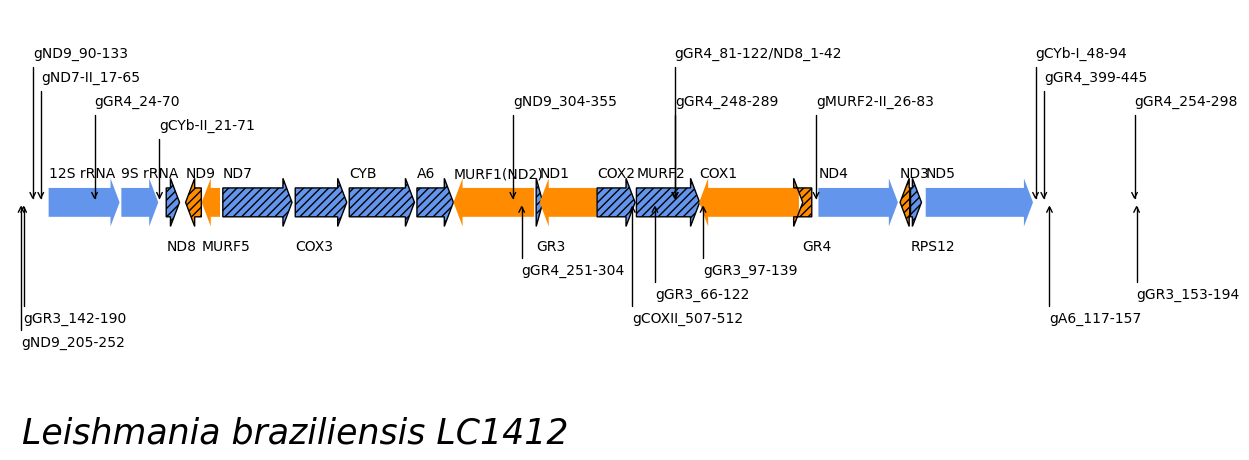

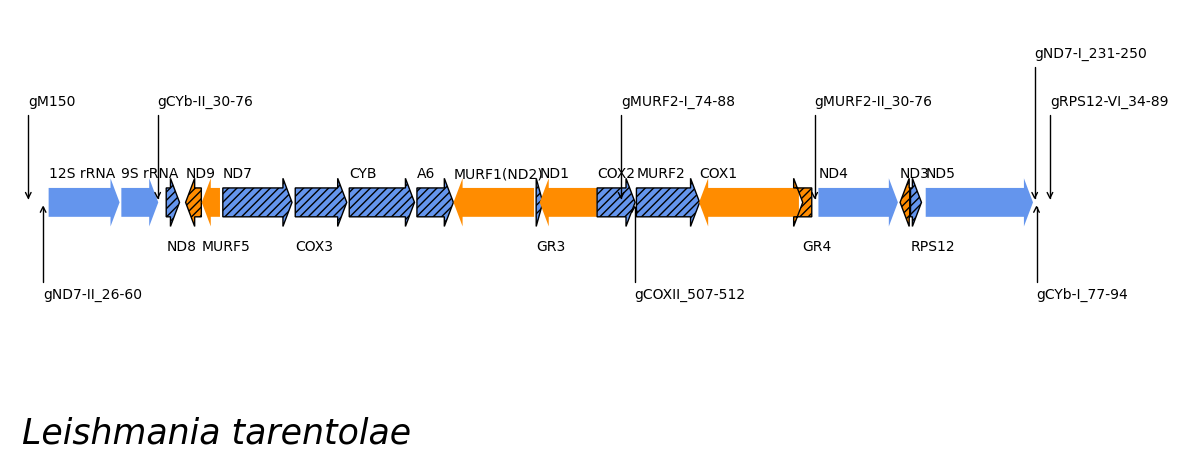

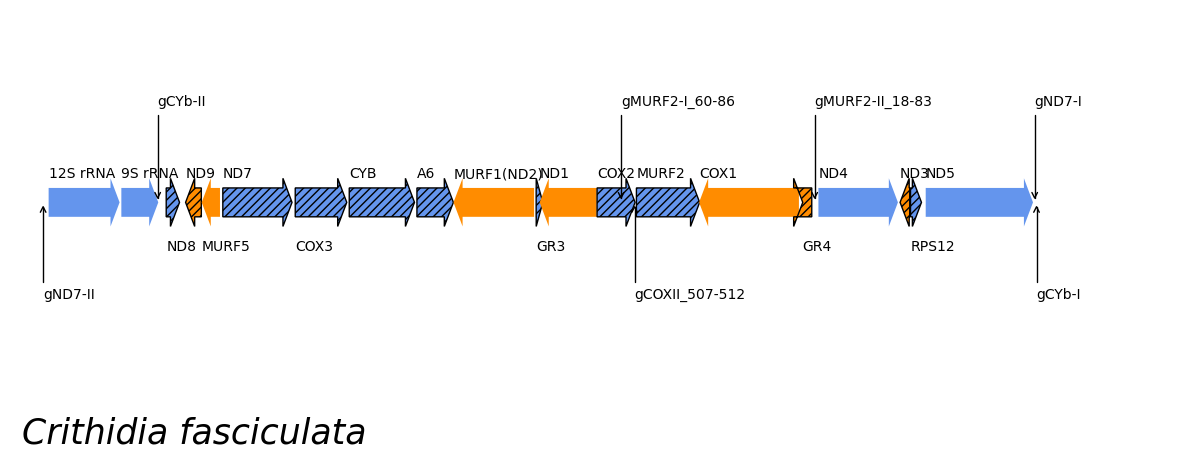

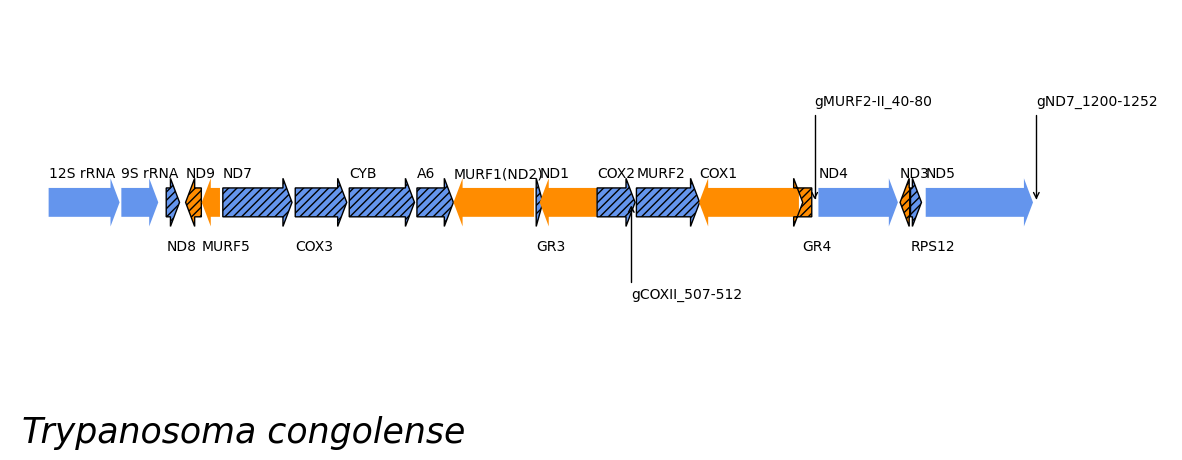

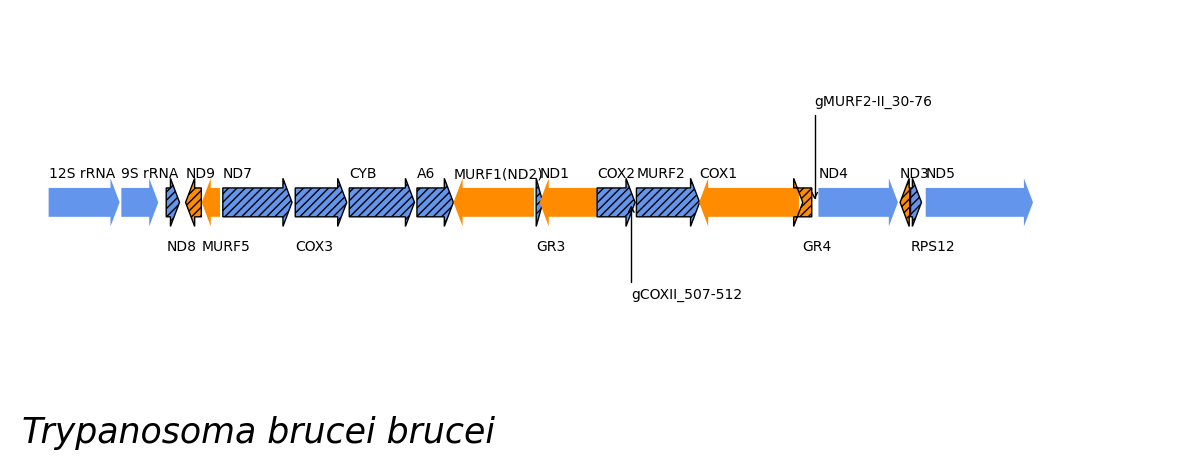

In [5]:
anotate_maxi('Leishmania peruviana HR78',hr78,adj=689-347)
anotate_maxi('Leishmania peruviana LCA04',lca04,adj=588-347)
anotate_maxi('Leishmania braziliensis LC1412',lc1412,adj=1610-347)
#anotate_maxi('Leishmania hybrid',HR434,adj=1571-347)
anotate_maxi('Leishmania tarentolae',lt,adj=0)
anotate_maxi('Crithidia fasciculata',cf,adj=0)
anotate_maxi('Trypanosoma congolense', tc,adj=11425-13090)
anotate_maxi('Trypanosoma brucei brucei',tb,adj=11425-13090)

